https://github.com/vivek3141/super-mario-rl/blob/master/Keras/keras-rl_deepq.py


In [0]:
!pip install gym-super-mario-bros
!pip install tensorflow-gpu

In [0]:
import random
import gym
import numpy as np
import gym_super_mario_bros
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from nes_py.wrappers import JoypadSpace
import cv2
from IPython.display import Image
from google.colab.patches import cv2_imshow


In [0]:
EPISODES = 5000

#Classe que define o agente
class DQNAgent:
    def __init__(self, state_size, action_size):
        #dimensão de um estado (Imagem original de 240x256 pxls com tres camadas)
        #Haverá de corte e redimensão
        self.state_size = state_size
        #Tamanho do conjunto de ações possíveis, depende do wrapper utilizado
        self.action_size = action_size
        #Memoria de replay, funciona como uma fila onde os ultimos 'maxlen'
        #estados são armazenados, também conhecido como 'Experience Replay Buffer'
        self.memory = deque(maxlen=2000)
        # Taxa de desconto, define a visibilidade do agente
        # 1.0 -> um agente com visibilidade perfeita
        # 0.0 -> agente so considera recompensa imediata
        self.gamma = 0.95    # discount rate
        # Taxa de aleatoriedade, sendo 1.0 aleatoriedade total. Utilizado pelo
        # metodo Epsilon-Greedy como uma alternativa ao dilema de exploration x
        # Exploitation. Começamos com 1.0 para popularmos a memoria de replay 
        # e começamos a decair esse valor até 0.02 (2% de aleatoriedade)
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        # Taxa de aprendizado, define o quao rapido o modelo se adapta ao problema.
        # Representa a diferença a ser atualizada nos pesos da rede através do 
        # Backpropagation
        self.learning_rate = 0.001
        # Constroi a rede 
        self.model = self._build_model()
        # Constroi a rede alvo
        # Uma rede alvo retorna o valor de Q(a', s') e é atualizada a cada
        # nK iterações, sendo uma copia da rede original. 
        self.target_model = self._build_model()
        # Copia os pesos da rede de treino para a rede alvo
        self.update_target_model()

    def _huber_loss(self, target, prediction):
        # sqrt(1+error^2)-1
        error = prediction - target
        return K.mean(K.sqrt(1+K.square(error))-1, axis=-1)

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=self._huber_loss,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            #print(state.shape)
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                # a = self.model.predict(next_state)[0]
                t = self.target_model.predict(next_state)[0]
                target[0][action] = reward + self.gamma * np.amax(t)
                # target[0][action] = reward + self.gamma * t[np.argmax(a)]
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


(240, 256)


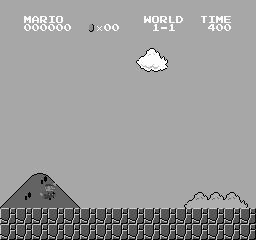

KeyboardInterrupt: ignored

In [23]:
if __name__ == "__main__":
    env = gym.make("SuperMarioBros-v0")
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    state_size = env.observation_space.shape[1]

    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    # agent.load("./save/cartpole-ddqn.h5")
    done = False
    batch_size = 32

    for e in range(EPISODES):
        state = env.reset()
        state = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)
        #state = np.reshape(state, [1, state_size])
        for time in range(500):
            # env.render()
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
          
            next_state = cv2.cvtColor(next_state, cv2.COLOR_BGR2GRAY)
            if(time == 3):
                print(next_state.shape)
                cv2_imshow(next_state)
            reward = reward if not done else -10
            #next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                agent.update_target_model()
                print("episode: {}/{}, score: {}, e: {:.2}"
                      .format(e, EPISODES, time, agent.epsilon))
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)